In [66]:
import numpy as np
import pandas as pd
import pickle as pkl
import random

import string
import re
import csv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [67]:
import warnings
warnings.simplefilter('ignore')

In [68]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [69]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [70]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [71]:
DATASET_PATH = 'K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/course_project_train.csv'
TEST_DATASET_PATH = 'K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/course_project_test.csv'
PREP_DATASET_PATH = 'K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/course_project_train_prep.csv'
FINAL_DATASET_PATH = 'K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/AKhmelev_predictions.pkl'

In [72]:
# Посмотрим данные тренировочного датасета

In [73]:
df = pd.read_csv(DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [75]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [76]:
# Преобразуем наблюдения Short Term и Long Term столбца Term в dummies

In [77]:
binary_to_numbers = {'Short Term': 1, 'Long Term': 0}
df['Term'] = df['Term'].replace(binary_to_numbers)
test_df['Term'] = test_df['Term'].replace(binary_to_numbers)

In [78]:
# Преобразуем наблюдения столбца Home Ownership

In [79]:
dummies = pd.get_dummies(df['Home Ownership'])
dummies_2 = pd.get_dummies(test_df['Home Ownership'])

In [80]:
df = pd.concat([df, dummies], axis='columns')
test_df = pd.concat([test_df, dummies_2], axis='columns')

In [81]:
# Преобразуем наблюдения столбца Purpose

In [82]:
dummies_3 = pd.get_dummies(df['Purpose'])
dummies_4 = pd.get_dummies(test_df['Purpose'])

In [83]:
df = pd.concat([df, dummies_3], axis='columns')
test_df = pd.concat([test_df, dummies_4], axis='columns')

In [84]:
# Извлечем числовые данные для переменной Years in current job

In [85]:
df['Years in current job'] = df['Years in current job'].replace('([^0-9]*)','', regex=True)
test_df['Years in current job'] = test_df['Years in current job'].replace('([^0-9]*)','', regex=True)

<AxesSubplot:>

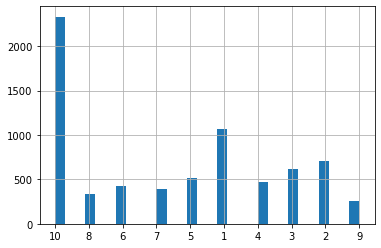

In [86]:
df['Years in current job'].hist(bins=30)

In [87]:
# Заполним пропуски в Annual Income модальными значениям

In [88]:
df['Annual Income nan'] = 0
test_df['Annual Income nan'] = 0

In [89]:
df.loc[df['Annual Income'].isna(), 'Annual Income nan'] = 1
test_df.loc[test_df['Annual Income'].isna(), 'Annual Income nan'] = 1

In [90]:
df.loc[df['Annual Income nan'] == 1, 'Annual Income'] = df['Annual Income'].mode()[0]
test_df.loc[test_df['Annual Income nan'] == 1, 'Annual Income'] = test_df['Annual Income'].mode()[0]

In [91]:
# Заполним пропуски Months since last delinquent модальными значениями

In [92]:
condition = (df['Months since last delinquent'].isna())
condition_2 = (test_df['Months since last delinquent'].isna())

In [93]:
df.loc[condition, 'Months since last delinquent'] = df['Months since last delinquent'].mode()[0]
test_df.loc[condition_2, 'Months since last delinquent'] = test_df['Months since last delinquent'].mode()[0]

In [94]:
# Заполним пропуски Credit Score модальными значениями

In [95]:
df['Credit Score nan'] = 0
test_df['Credit Score nan'] = 0

In [96]:
df.loc[df['Credit Score'].isna(), 'Credit Score nan'] = 1
test_df.loc[test_df['Credit Score'].isna(), 'Credit Score nan'] = 1

In [97]:
df.loc[df['Credit Score nan'] == 1, 'Credit Score'] = df['Credit Score'].mode()[0]
test_df.loc[test_df['Credit Score nan'] == 1, 'Credit Score'] = test_df['Credit Score'].mode()[0]

In [98]:
# Заполним пропуски в Years in current job модальными значениям

In [99]:
df['Years in current job nan'] = 0
test_df['Years in current job nan'] = 0

In [100]:
df.loc[df['Years in current job'].isna(),'Years in current job nan'] = 1
test_df.loc[test_df['Years in current job'].isna(),'Years in current job nan'] = 1

In [101]:
df.loc[df['Years in current job nan'] == 1, 'Years in current job'] = df['Years in current job'].mode()[0]
test_df.loc[test_df['Years in current job nan'] == 1, 'Years in current job'] = test_df['Years in current job'].mode()[0]

In [102]:
# Заполним пропуски в Bankruptcies модальными значениям

In [103]:
condition_3 = (df['Bankruptcies'].isna())

condition_4 = (test_df['Bankruptcies'].isna())
        
df.loc[condition_3, 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
test_df.loc[condition_4, 'Bankruptcies'] = test_df['Bankruptcies'].mode()[0]

In [104]:
df['Years in current job'] = df['Years in current job'].astype(float)
test_df['Years in current job'] = test_df['Years in current job'].astype(float)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [106]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [107]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [108]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

In [109]:
TARGET_NAME = 'Credit Default'

NUMERIC_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                         'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                         'Months since last delinquent', 'Bankruptcies', 'Term', 
                         'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'] 

NEW_FEATURE_NAMES = ['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 'business loan', 'buy a car', 
                     'buy house', 'debt consolidation', 'educational expenses', 'other', 'Annual Income nan',
                     'Credit Score nan', 'Years in current job nan']

In [110]:
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

In [111]:
test_df = test_df[FEATURE_NAMES_SELECTED]

In [112]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

In [113]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [114]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [115]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [116]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      4047
           1       0.70      0.51      0.59      3156

    accuracy                           0.69      7203
   macro avg       0.69      0.67      0.67      7203
weighted avg       0.69      0.69      0.68      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1340
           1       0.58      0.54      0.56       535

    accuracy                           0.76      1875
   macro avg       0.70      0.69      0.69      1875
weighted avg       0.75      0.76      0.75      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1131  209
1                248  287


In [117]:
X_train.shape, X_test.shape, test_df.shape

((7203, 27), (1875, 27), (2500, 27))

In [118]:
X_test

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Rent,business loan,buy a car,buy house,debt consolidation,educational expenses,other,Annual Income nan,Credit Score nan,Years in current job nan
124,1.423148,1.090316,-0.110953,-0.026674,0.480373,0.006336,-0.340979,-0.526838,-0.337099,-1.690569,...,0,0,0,0,1,0,0,0,0,0
4041,-0.408750,-0.896825,-0.110953,1.399395,-1.365831,-0.016832,-0.340979,-0.526838,-0.337099,0.591517,...,1,0,0,0,1,0,0,1,1,0
2588,-0.408750,1.090316,-0.110953,-1.045295,0.182140,-0.020341,-0.340979,-0.526838,-0.337099,0.591517,...,1,0,0,0,0,0,1,1,1,1
3566,-0.774794,-0.896825,-0.110953,1.195671,-0.755164,0.047939,-0.340979,-0.526838,-0.337099,0.591517,...,0,0,0,0,1,0,0,0,0,0
2660,-0.408750,1.090316,-0.110953,0.380774,-0.996590,-0.039816,-0.340979,1.763018,-0.337099,0.591517,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,-0.616761,-0.329071,-0.110953,0.380774,-0.556342,-0.015669,-0.340979,-0.526838,-0.337099,0.591517,...,1,0,0,0,1,0,0,0,0,0
6323,-0.692839,1.090316,-0.110953,-0.230398,2.156158,-0.026015,-0.340979,1.148667,-0.337099,0.591517,...,0,0,0,0,0,0,0,0,0,1
2701,0.033742,-0.896825,-0.110953,-0.637847,-1.337428,-0.040049,-0.340979,-0.526838,-0.337099,0.591517,...,1,0,0,0,1,0,0,0,0,0
958,0.137970,1.090316,-0.110953,-1.860192,-0.371721,-0.055753,-0.340979,-0.526838,-0.337099,0.591517,...,1,0,0,0,0,0,1,0,0,0


In [63]:
test_df

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Rent,business loan,buy a car,buy house,debt consolidation,educational expenses,other,Annual Income nan,Credit Score nan,Years in current job nan
0,-0.327678,-0.617384,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,2.623332,-0.299225,0.585973,...,1,0,0,0,1,0,0,1,1,0
1,-1.284626,-1.470124,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,-0.936079,-0.299225,0.585973,...,1,0,0,0,0,1,0,0,0,0
2,-0.174004,-0.901631,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.476800,-0.299225,0.585973,...,0,0,0,0,1,0,0,0,0,0
3,-0.092251,1.088097,-0.091141,0.992538,-0.182805,-0.168202,-0.289398,2.623332,-0.299225,0.585973,...,0,0,0,0,1,0,0,0,0,0
4,1.259550,-0.048890,-0.091141,-0.038006,0.727138,0.328576,-0.289398,-0.476800,-0.299225,-1.706565,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.333820,1.088097,-0.091141,0.580320,1.485423,-0.100166,1.497011,2.508512,2.502503,0.585973,...,0,0,0,0,1,0,0,0,0,0
2496,-0.327678,-1.185878,-0.091141,0.786429,-0.182805,0.679515,-0.289398,3.025201,-0.299225,0.585973,...,0,0,0,0,1,0,0,1,1,0
2497,-0.150764,-1.185878,-0.091141,7.588024,-0.761859,0.658776,-0.289398,-0.476800,-0.299225,0.585973,...,0,0,0,0,1,0,0,0,0,0
2498,-0.691522,1.088097,-0.091141,0.580320,1.444062,0.155595,-0.289398,-0.476800,-0.299225,0.585973,...,1,0,0,0,1,0,0,0,0,0


In [67]:
submit = pd.read_csv('K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/AKhmelev_predictions.csv')
submit.head()

,Credit Default
0,100
1,100
2,100
3,100
4,100


In [65]:
predictions = model_lr.predict(X_test)
predictions

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [69]:
submit['Credit Default'] = predictions
submit.head()

,Credit Default
0,0
1,0
2,1
3,0
4,0


In [70]:
submit.to_csv('K://2020/Programming/Data Science/Библиотеки_Python_2/Проект/AKhmelev_predictions.csv', index=False)